# JWST Data Analysis Workshop: “Science Sessions”
## The Transiting Exoplanet session

This notebook is made for the workshop sessions of the *Spring Symposium 2023 'Planetary systems and the origins of life in the era of JWST'*. We are going to go trough simple steps of JWST data analysis to produce a transit spectrum of **WASP-39 b using ERS NIRSpec PRISM observations**.
<br><br>
authors: Amélie Gressier (agressier@stsci.edu), Natalie Allen (nallen19@jhu.edu) and Néstor Espinoza (nespinoza@stsci.edu)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from jwst import datamodels

In [7]:
datafolder ='/Users/agressier/Documents/jwst_data/0366-nirspec-prism/'

### Introduction: let's take a look at the data

We will work with the `*rampfitstep.fits` files. These are products of the stage 1 JWST detector pipeline where the first steps of the pipeline are performed, i.e., linearity, superbias, saturation correction. 
<br><br>
First, let's load the data and take a look at the files.

In [8]:
#Load each segment using datamodels
tso1 = datamodels.open(datafolder+'jw01366004001_04101_00001-seg001_nrs1_1_rampfitstep.fits')
tso2 = datamodels.open(datafolder+'jw01366004001_04101_00001-seg002_nrs1_1_rampfitstep.fits')
tso3 = datamodels.open(datafolder+'jw01366004001_04101_00001-seg003_nrs1_1_rampfitstep.fits')
tso4 = datamodels.open(datafolder+'jw01366004001_04101_00001-seg004_nrs1_1_rampfitstep.fits')

We can use the search function to get metadata.

In [199]:
tso1.search('')

root (AsdfObject)
└─meta (dict)
  └─instrument (dict)
    └─grating (str): PRISM

In [11]:
tso1.shape

(6100, 32, 512)

The dimensions of each segment are (`nintegrations, nrows, ncolumns`). The integrations corresponds to the time dimension of the transit/eclipse observation, the number of rows and columns are the dimension of the detector subarray.
<br><br>
Let's put all the segments into one single array.

In [209]:
# Load data on a single array:
tso = np.vstack((tso1.data, tso2.data))
tso = np.vstack((tso, tso3.data))
tso = np.vstack((tso, tso4.data))

# Errors:
tso_err = np.vstack((tso1.err, tso2.err))
tso_err = np.vstack((tso_err, tso3.err))
tso_err = np.vstack((tso_err, tso4.err))

# Data-quality flags:
tso_dq = np.vstack((tso1.dq, tso2.dq))
tso_dq = np.vstack((tso_dq, tso3.dq))
tso_dq = np.vstack((tso_dq, tso4.dq))

In [13]:
tso.shape

(21500, 32, 512)

In [205]:
#Load the times of the observations
times = np.append(tso1.int_times['int_mid_BJD_TDB'], tso2.int_times['int_mid_BJD_TDB'])
times = np.append(times, tso3.int_times['int_mid_BJD_TDB'])
times = np.append(times, tso4.int_times['int_mid_BJD_TDB'])

The transit of WASP-39 b was observed with the NIRSpec PRISM mode and the SUB512 subarray (32x512). The observation is centred arount the transit and lasts 8h23, which corresponds to 21500 integrations in a single exposure. 

In [14]:
#Generate a median frame
median_tso = np.median(tso, axis = 0) 

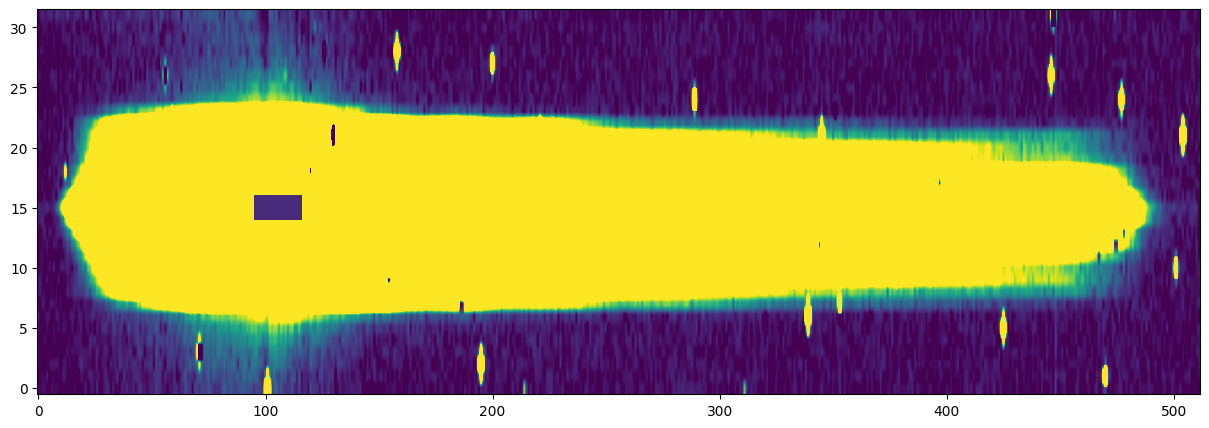

In [15]:
#Plot the median frame
plt.figure(figsize=(15,5))
im = plt.imshow(median_tso, origin = 'lower', aspect = 'auto')
im.set_clim(-2,15)

Let's see if we can observe the transit from this first image ! We add the light inside a small portion of the median image.

In [16]:
postage = tso[:,10:20, 200:250]

In [17]:
timeseries = np.sum(postage, axis = (1,2))

Text(0.5, 0, 'Integration number')

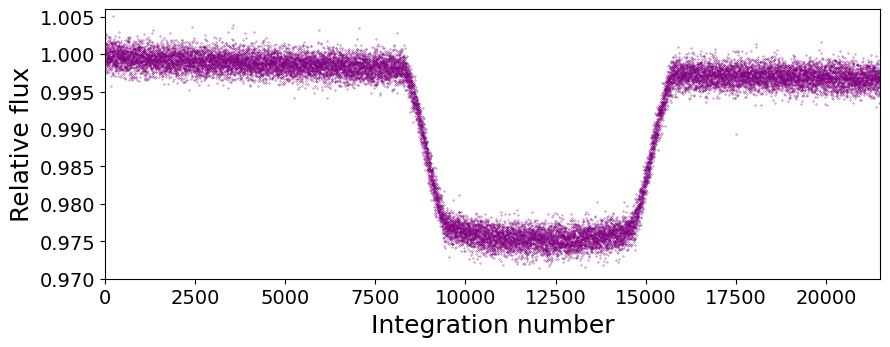

In [18]:
plt.figure(figsize=(10,3.5))
plt.plot(timeseries / np.median(timeseries[0:50]), '.', color = 'purple',ms=0.5)
plt.ylim(0.97,1.006)
plt.xlim(0, len(timeseries))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
    
plt.ylabel('Relative flux', fontsize = 18)
plt.xlabel('Integration number', fontsize = 18)

Amazing ! We have our first transit from JWST data ! We can see a ramp in time, this is a systematic effect that needs to be corrected. We will try to fix it later.

In [157]:
#define some indexes in and out of the transit event that will be useful later.
t_integrations = np.arange(len(times))
idx_oot = np.where((t_integrations<7000)|(t_integrations>17500))
idx_it = np.where((t_integrations>10000)&(t_integrations<14000))

### 1- Stellar flux extraction

Let's extract the stellar spectrum in the simpliest way, by adding the flux coming from all the pixels in a given column in the range of y-pixels we select.

In [212]:
#define some range in the x-axis and y-axis to extract the flux
xp = np.arange(8,490,1)
yp = np.array([15]*len(xp))

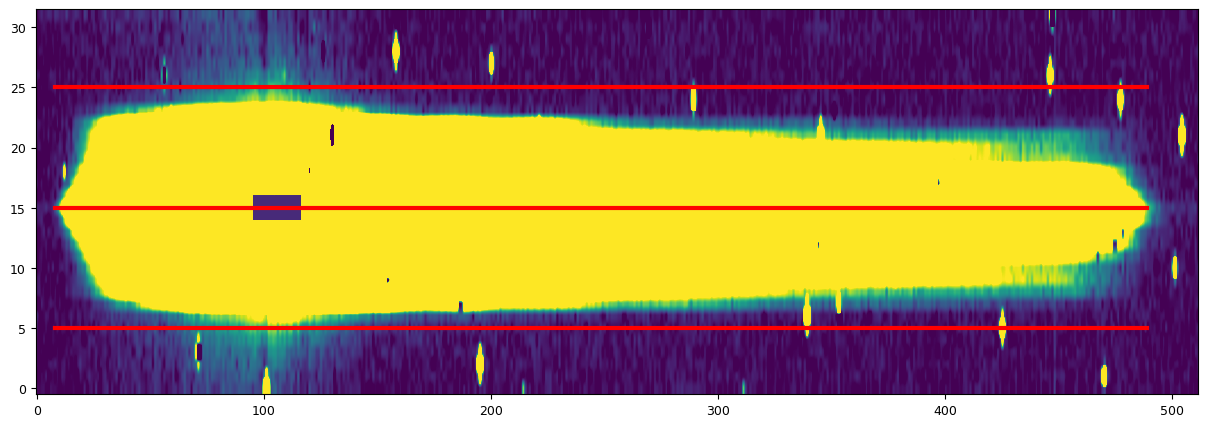

In [213]:
plt.figure(figsize=(15,5))
im = plt.imshow(median_tso, origin = 'lower', aspect = 'auto')
plt.plot(xp,yp, lw=3, color='r')
plt.plot(xp,yp-10, lw=3, color='r')
plt.plot(xp,yp+10, lw=3, color='r')
im.set_clim(-2,15)

In [23]:
#We add all the flux in the given y range for each column x and each integration.
spectra_extracted = np.zeros([tso.data.shape[0], len(xp)])
spectra_extracted_err = np.zeros([tso.data.shape[0], len(xp)])
for i in range (0,len (xp)) :
    spectra_extracted[:,i] = np.nansum(tso[:,5:25,xp[i]], axis = (1))
    spectra_extracted_err[:,i] = np.sqrt(np.nansum((tso_err[:,5:25,xp[i]])**2, axis = (1)))

In [206]:
spectra_extracted.shape

(21500, 482)

Text(0, 0.5, 'DN /s ')

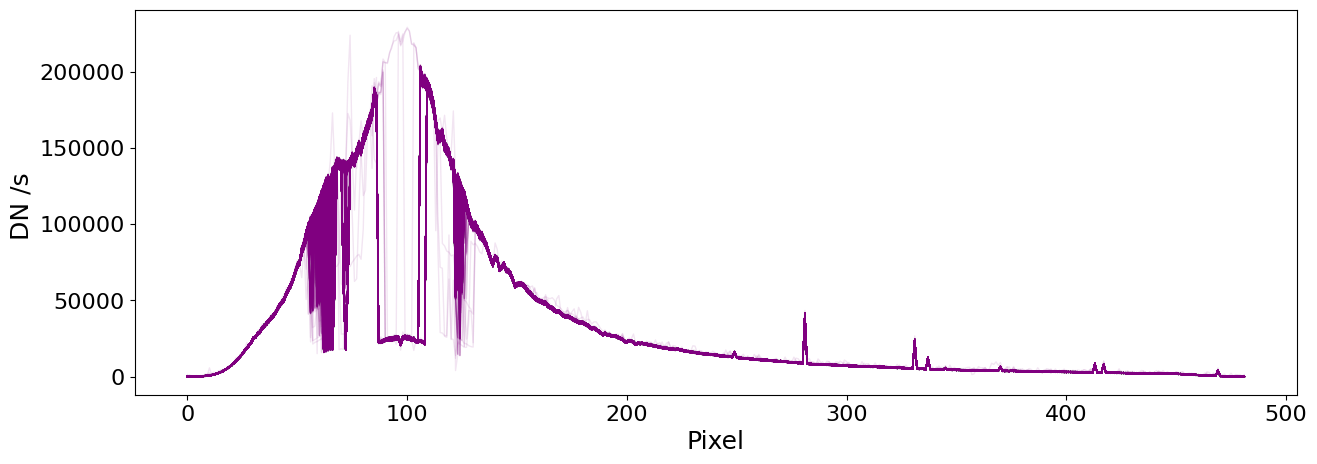

In [24]:
plt.figure(figsize=(15,5))
for i in range(spectra_extracted.shape[0]):    
    plt.plot(spectra_extracted[i,:], color = 'purple', alpha = 0.1, lw=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Pixel', fontsize = 18)
plt.ylabel('DN /s ', fontsize = 18)

We can clearly see the saturated part around pixel 100. Let's get rid of some outliers.

In [25]:
def get_mad_sigma(x, median):
    """
    This function returns the MAD-based standard-deviation.
    """

    mad = np.nanmedian( np.abs ( x - median ) )

    return 1.4826*mad

In [26]:
master_spectra = np.zeros(spectra_extracted.shape)

for i in range(spectra_extracted.shape[0]):
    master_spectra[i, :] = spectra_extracted[i,:] / np.nanmedian(spectra_extracted[i,:])

In [27]:
master_spectrum = np.zeros(spectra_extracted.shape[1])
sigma_master_spectrum = np.zeros(spectra_extracted.shape[1])


for i in range(spectra_extracted.shape[1]):
    median = np.nanmedian(master_spectra[:, i])
    master_spectrum[i], sigma_master_spectrum[i] = median, \
                                                     get_mad_sigma(median, master_spectra[:, i])

In [28]:
corrected_spectra = np.copy(spectra_extracted)
corrected_spectra_err = np.copy(spectra_extracted_err)


for i in range(spectra_extracted.shape[0]):
    
    # Get median to scale:
    median = np.median(spectra_extracted[i, :])

    # Scale master spectrum and sigma:
    model = master_spectrum * median
    sigma = sigma_master_spectrum * median
    
    # Identify bad pixels/columns:
    residuals = np.abs(spectra_extracted[i, :] - model)
    idx_bad = np.where(residuals > 5 * sigma)[0]
    
    # Replace:
    if len(idx_bad) != 0:
        
        corrected_spectra[i, idx_bad] = model[idx_bad]
        corrected_spectra_err[i, idx_bad] = sigma[idx_bad]
        
        
    

Text(0, 0.5, 'DN /s ')

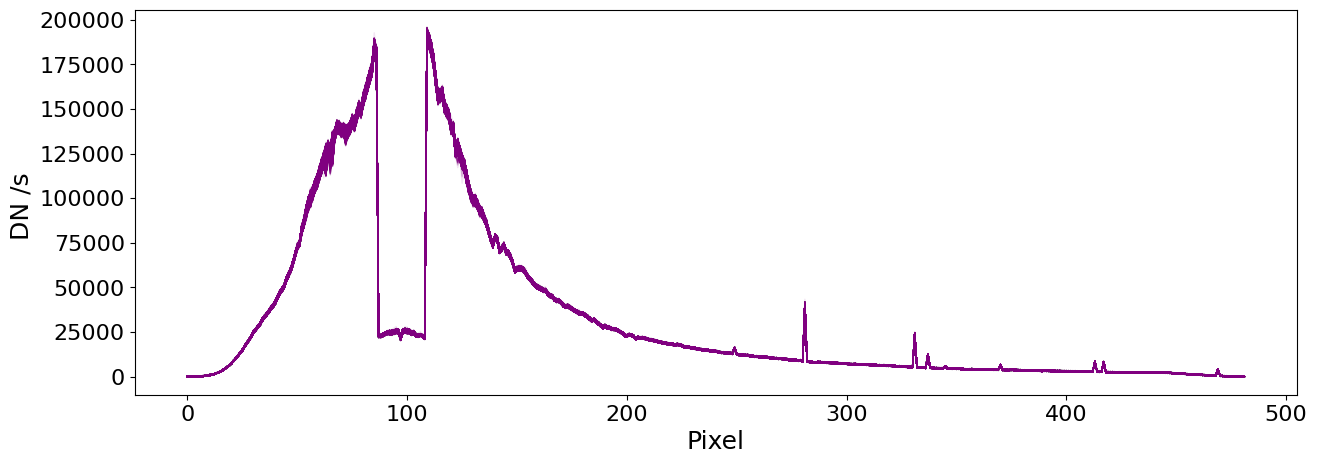

In [29]:
plt.figure(figsize=(15,5))
for i in range(spectra_extracted.shape[0]):    
    plt.plot(corrected_spectra[i,:], color = 'purple', alpha = 0.1, lw=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Pixel', fontsize = 18)
plt.ylabel('DN /s ', fontsize = 18)

This looks great ! First, let's transform the x-pixels into wavelengths. The indexes I used are set to match our extraction to the NIRSpec PRISM wavelength solution. Let's not change those right now but bare in mind that this will have to be modified if the extraction range changes. To get the wavelength solution correclty you can take a look at this tutorial: https://stsci.box.com/s/6c2tg86ruzpxykp8b7pvd1q2ysdnc3p5

In [30]:
wavelength_solution=np.loadtxt('/Users/agressier/Documents/jwst_workbooks/ERS_WASP-39b_nirspec_wk/wavelength_solutions_prism.txt')

In [426]:
spectra = {}
spectra['wavelength'] = wavelength_solution
spectra['spectra'] = []
spectra['errors'] = []

for i in range(tso.shape[0]):
    spectra['spectra'].append(corrected_spectra[i, 22:454]) # let's not change these indexes for now they match the wavelength solution
    spectra['errors'].append(corrected_spectra_err[i, 22:454])

Text(0, 0.5, 'DN /s ')

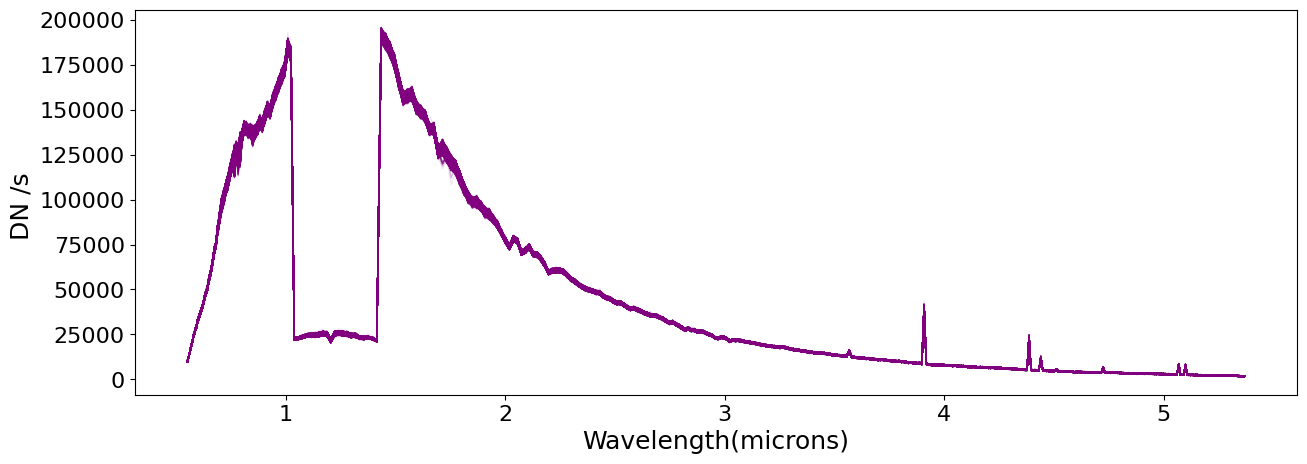

In [427]:
plt.figure(figsize=(15,5))
for i in range(spectra_extracted.shape[0]):
    plt.plot(spectra['wavelength'],spectra['spectra'][i], color = 'purple', alpha = 0.1, lw=1)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Wavelength(microns)', fontsize = 18)
plt.ylabel('DN /s ', fontsize = 18)

### 2-  White light curve



In [428]:
lcs={}

In [429]:
lcs['times'] = times + 2400000.5
t = lcs['times']

First, we create the white light curve by integrating over all wavelengths.

In [430]:
lcs['white light'] = {}
lc = np.array([])
lcerr = np.array([])
for i in range(len(spectra['spectra'])):
    lc = np.append(lc, np.sum(spectra['spectra'][i]))
    lcerr = np.append(lcerr, np.sqrt(np.sum(spectra['errors'][i]**2)))

lcs['white light']['flux'] = np.copy(lc)
lcs['white light']['errors'] = np.copy(lcerr)

In [431]:
flux, flux_err = lcs['white light']['flux'], lcs['white light']['errors']
flux, flux_err = flux / np.nanmedian( flux[idx_oot] ), flux_err / np.nanmedian( flux[idx_oot] )

Text(0, 0.5, 'Relative flux')

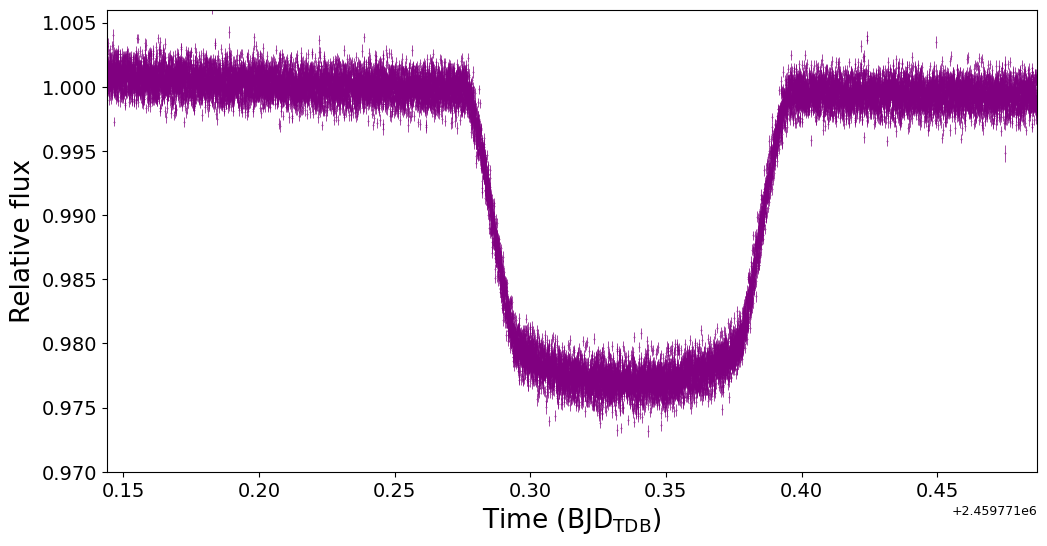

In [432]:
plt.figure(figsize=(12,6))
plt.errorbar(t, flux, flux_err, fmt = '.', color = 'purple', ms = 0.5, elinewidth = 0.5)  
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(np.min(t), np.max(t))
plt.ylim(0.97,1.006)
plt.xlabel(r'Time (BJD$_{\rm TDB}$)', fontsize = 19)
plt.ylabel('Relative flux', fontsize = 19)

Let's take care of the linear trend we saw before. We fit a line to the out of transit flux and then remove it from the data.

In [433]:
coef = np.polyfit(t[idx_oot],flux[idx_oot],1)
linear_func = np.poly1d(coef) 

In [434]:
#We create an array f_oot for visualization
f_int=np.empty((10500))
f_int[:]=np.nan
f_oot=np.concatenate((flux[:7000],f_int))
f_oot=np.concatenate((f_oot,flux[17500:]))

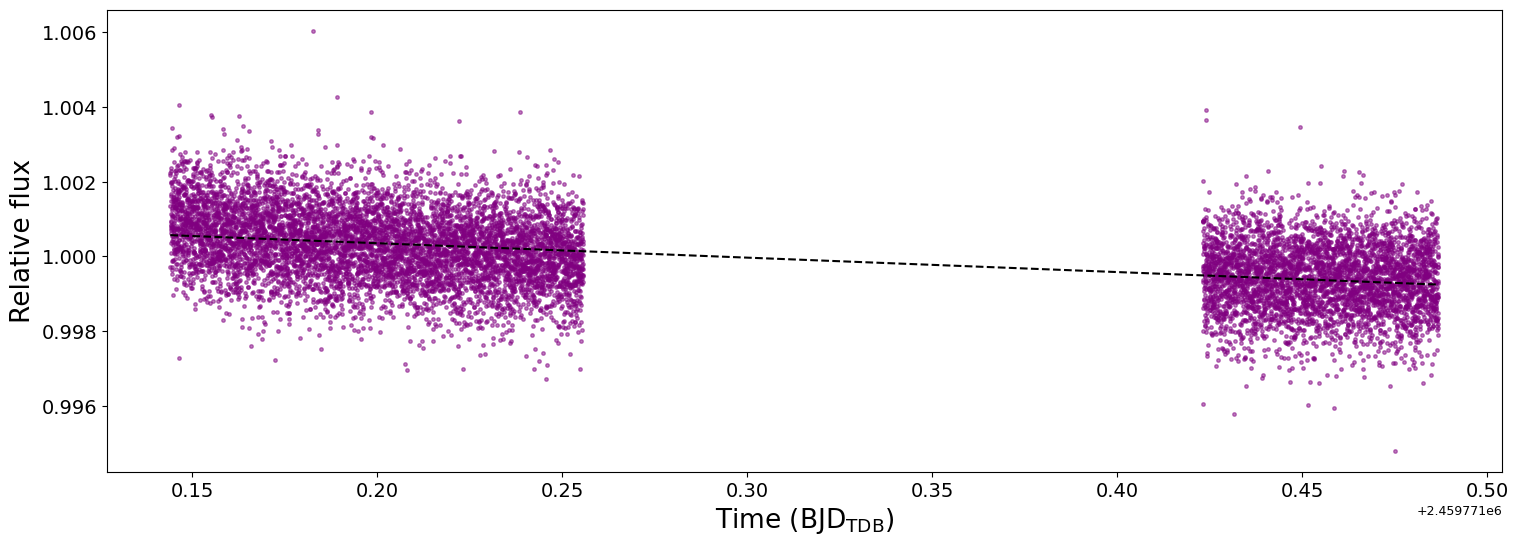

In [435]:
plt.figure(figsize=(18,6))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'Time (BJD$_{\rm TDB}$)', fontsize = 19)
plt.ylabel('Relative flux', fontsize = 19)

plt.plot(t,f_oot, '.', color='purple', alpha=0.5)
plt.plot(t,linear_func(t), '--', color='k')


In [436]:
flux_corrected = flux/linear_func(t)

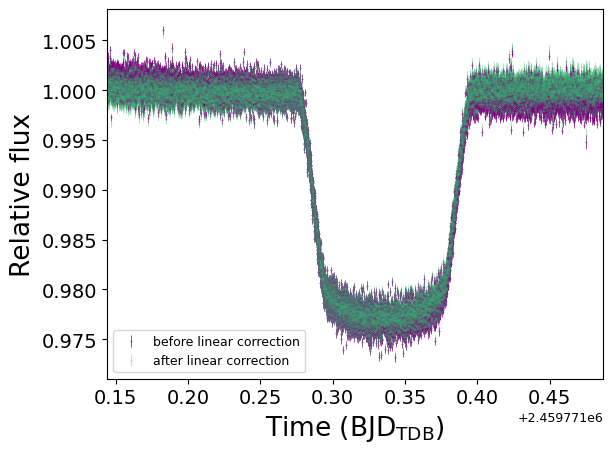

In [437]:
plt.figure()
plt.errorbar(t, flux, flux_err, fmt = '.', color = 'purple', ms = 0.5, elinewidth = 0.5, label ='before linear correction')  
plt.errorbar(t, flux_corrected, flux_err, fmt = '.', color = 'mediumseagreen', ms = 0.5, elinewidth = 0.5, alpha=0.5,label ='after linear correction') 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(np.min(t), np.max(t))
plt.xlabel(r'Time (BJD$_{\rm TDB}$)', fontsize = 19)
plt.ylabel('Relative flux', fontsize = 19)
plt.legend()

Congrat's ! We performed our first data analysis correction :)

### 3- Spectral light curves

Let's create the spectral light curves at pixel resolution. 

In [438]:
lcs['spectral light curves']={}

In [439]:
# Start saving from the smallest wavelength and up:
idx_non_zero = np.where( (spectra['wavelength'] != 0.0) & ~(np.isnan(spectra['wavelength']))  )[0]
current_wavelength = np.min(spectra['wavelength'][idx_non_zero])

while True:
    idx = np.where(spectra['wavelength'] == current_wavelength)[0]
    lc = np.array([])
    lcerr = np.array([])
    for i in range(len(spectra['spectra'])):
        lc = np.append(lc, spectra['spectra'][i][idx])
        lcerr = np.append(lcerr, spectra['errors'][i][idx])

    lcs['spectral light curves'][current_wavelength] = {}
    lcs['spectral light curves'][current_wavelength]['flux'] = np.copy(lc)
    lcs['spectral light curves'][current_wavelength]['errors'] = np.copy(lcerr)

    # Go to the next wavelengths:
    idx_next = np.where((spectra['wavelength'] != current_wavelength) & (spectra['wavelength'] > current_wavelength))[0]

    if len(idx_next) == 0:
            break
    else:
            current_wavelength = np.min(spectra['wavelength'][idx_next])

Text(0, 0.5, 'Relative flux + offset')

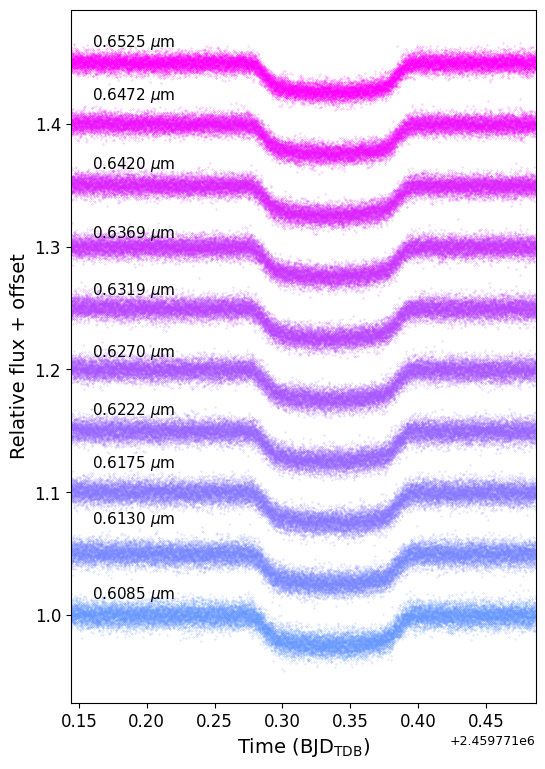

In [503]:
plt.figure(figsize = (6,9))
delta = 0.05

counter = 0

pixels = spectra['wavelength'][15:25]

colormap = plt.get_cmap('cool')

color = [colormap(k) for k in np.linspace(0.4, 1.0, len(pixels))]

for i,c in zip(pixels, color):
    lc, lcerr = lcs['spectral light curves'][i]['flux'], lcs['spectral light curves'][i]['errors']
    rel_lc = (lc / np.median(lc[idx_oot]))/linear_func(t)
    rel_lc_err = lcerr / np.median(lc[idx_oot])
    plt.plot(t, rel_lc + counter * delta, '.',ms=0.5,
                 alpha = 0.5, zorder = 1, color = c)
    
    
    plt.text(t[1000],rel_lc[0]+0.01 + counter * delta, "{:0.4f}".format(i) + str(r' ${\mu}$m'), fontsize=11)
    counter += 1

plt.xlim(np.min(t), np.max(t))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel(r'Time (BJD$_{\rm TDB}$)', fontsize = 14)
plt.ylabel('Relative flux + offset', fontsize = 14)

### 4- Transmission spectrum

Were are going to create a transmission spectrum with a simple computation using the spectral light curves. The correct way of doing it is to fit the spectral light curves with a transit model.

In [444]:
#function to compute weighted mean and errors
def waverage(x, x_err):
    x=np.array(x)
    xerr=np.array(x_err)
    wx=1/(x_err**2)
    wav =np.sum(x*wx,0)/np.sum(wx,0)
    wav_err= 1/np.sqrt((np.sum(wx,0)))
    return wav, wav_err

In [445]:
wavs = list(lcs['spectral light curves'].keys())

We can do it at the pixel resolution:

In [468]:
transmission_spectrum = np.zeros((len(wavs),3))

In [471]:
for i in range(0,len(wavs)):
    transmission_spectrum[i,0] = wavs[i]
    lc= lcs['spectral light curves'][wavs[i]]['flux']
    lcerr= lcs['spectral light curves'][wavs[i]]['errors']
    
    xin, xerrin = waverage(lc[idx_it],lcerr[idx_it])
    xout, xerrout = waverage(lc[idx_oot],lcerr[idx_oot])
    transmission_spectrum[i,1]=(xout-xin)/np.median(lc[idx_oot])
    transmission_spectrum[i,2] = np.sqrt(xerrin**2+xerrout**2)/np.median(lc[idx_oot])

Text(0, 0.5, 'Transit depth')

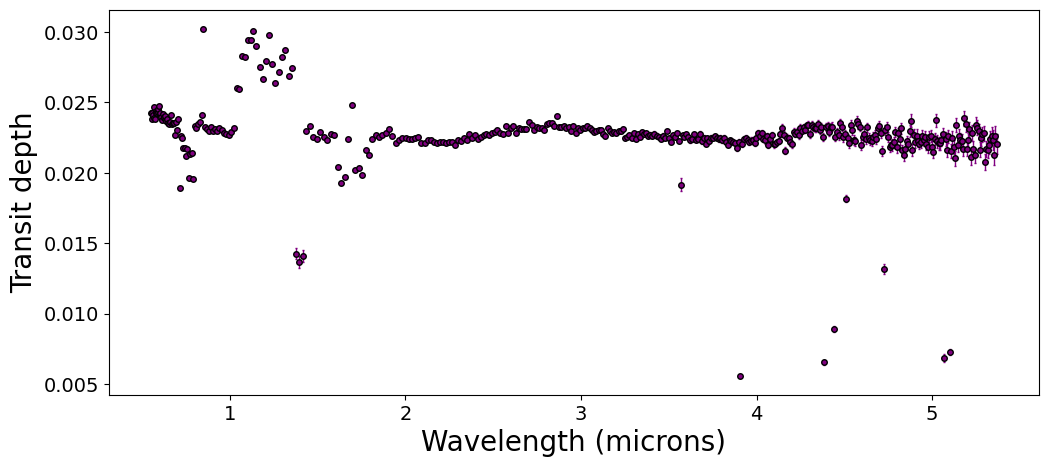

In [472]:
plt.figure(figsize=(12,5))
plt.errorbar(transmission_spectrum[:,0],transmission_spectrum[:,1], yerr=transmission_spectrum[:,2], fmt='.', color = 'purple', mec='k', elinewidth=1,capsize=1, ms=8)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Wavelength (microns)', fontsize =20)
plt.ylabel('Transit depth', fontsize =20)

Let's get rid of some outliers.

In [473]:
residuals = transmission_spectrum[:,1] - median_filter(transmission_spectrum[:,1], 11)
sigma = get_mad_sigma(np.nanmedian(residuals), residuals)
idx_outliers = np.where(np.abs(residuals) > 5*sigma)[0]

In [474]:
if len(idx_outliers) > 0:
            
            print('Found', len(idx_outliers), '! Replacing...')
            
            for idx in idx_outliers:
                
                if idx == 0:
                    
                    replacement = 1
                    
                elif idx == len(residuals)-1:
                    
                    replacement = len(residuals)-2
                    
                else:
                    
                    replacement = idx + 1
                    
                    if replacement in idx_outliers:
                        if replacement == len(residuals) -1:
                            replacement = replacement -2
                        else:    
                        
                            replacement = idx + 2
                        
                            transmission_spectrum[idx, 1] =transmission_spectrum[replacement, 1]
                            transmission_spectrum[idx, 2] =transmission_spectrum[replacement, 2]

Found 29 ! Replacing...


(0.021, 0.0245)

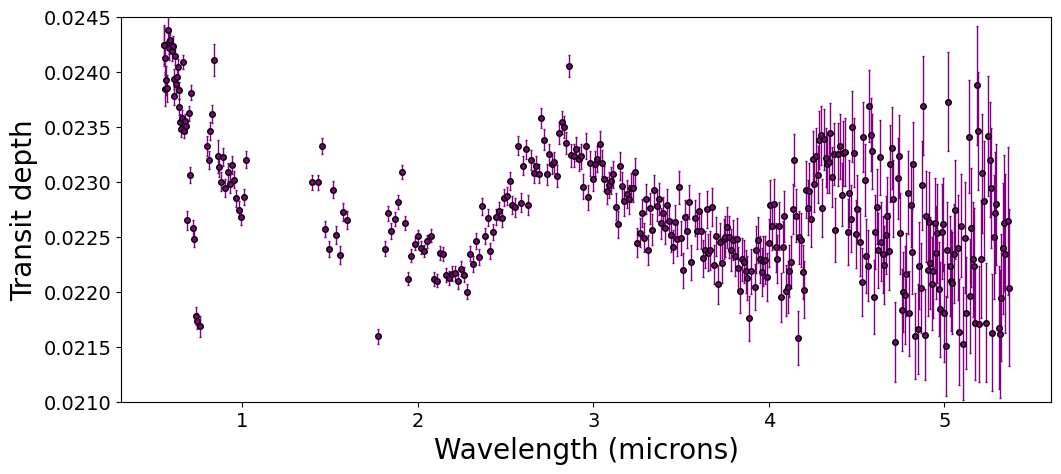

In [504]:
plt.figure(figsize=(12,5))
plt.errorbar(transmission_spectrum[:,0],transmission_spectrum[:,1], yerr=transmission_spectrum[:,2], fmt='.', color = 'purple', mec='k', elinewidth=1,capsize=1, ms=8)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Wavelength (microns)', fontsize =20)
plt.ylabel('Transit depth', fontsize =20)
plt.ylim(0.021,0.0245)

There are still some outliers in particular in the saturated region, but if we zoom in, the transmission spectrum looks pretty nice !
<br>
You can try at home to create a binned version of this spectrum.

You can simply suppress the last outliers for the spectral interpretation with the next lines. 

In [514]:
idx_outliers_full = np.where((transmission_spectrum[:,1]<0.0215)|(transmission_spectrum[:,1]>0.0245) )
transmission_spectrum[idx_outliers_full,1] =np.nan


Text(0, 0.5, 'Transit depth')

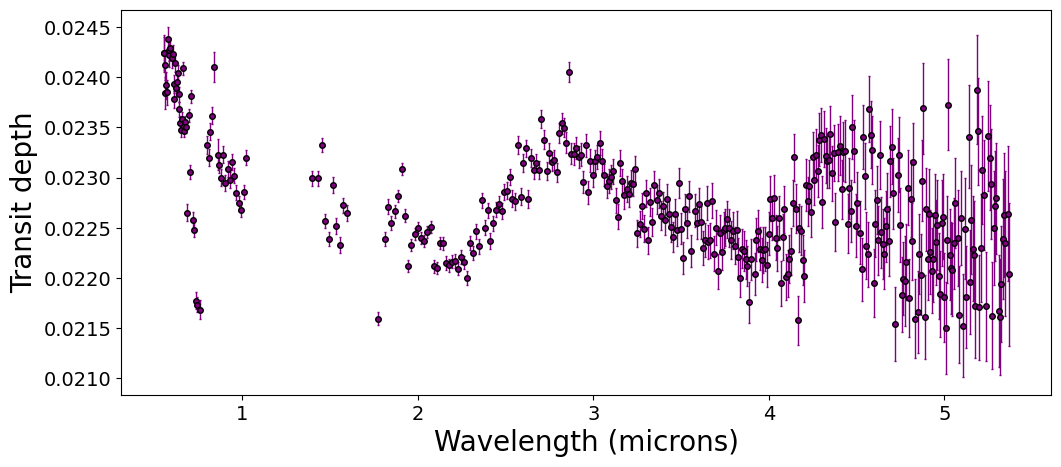

In [515]:
plt.figure(figsize=(12,5))
plt.errorbar(transmission_spectrum[:,0],transmission_spectrum[:,1], yerr=transmission_spectrum[:,2], fmt='.', color = 'purple', mec='k', elinewidth=1,capsize=1, ms=8)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Wavelength (microns)', fontsize =20)
plt.ylabel('Transit depth', fontsize =20)

Great ! We have an first approximate of the transmission spectrum of WASP-39 b between 0.5 and 5 microns. Let's save your favorite results and try to interpret it.

In [516]:
np.savetxt('w39b_nirspec_prism_pixel_resolution.dat', transmission_spectrum)

### 5-Conclusion and going further

We performed our first JWST data analysis using simple tools and functions. This is a **first insight** into transit spectroscopy.
To properly extract the stellar spectrum, adjust the light curves and obtain a spectrum, additionnal steps have to be considered. We will not have the time to go into the details of such steps now but you can do it at home.

I suggest you ceate a python environment and install some tools. For JWST data analysis you can use _transitspectroscopy_ or the _Eureka_ pipeline. Many tools exist for the light curve fitting, you can install _juliet_ for example.


In [65]:
import juliet
import transitspectroscopy as ts
import copy
import pickle
import corner

**Handling background and 1/f noise**

You might want to subtract the background and correct for the 1/f noise before extracting the stellar spectrum. Next is a set of functions to do so.

In [117]:
def correct_1f(median_frame, frame, x, y, min_bkg = 20, max_bkg = 35, mask = None, scale_factor = 1.):
    
    new_frame = np.copy(frame)
    
    # The scale-factor accounts for the fact that the transit "dims" the frame (which is almost completely 
    # illuminated). Transit spectral features add only a tiny ammount of scaling (below our precisions), 
    # so we don't need to account for that:
    ms = frame - median_frame * scale_factor
    
    # Go column-by-column substracting values around the trace:
    for i in range(len(x)):
        
        column = x[i]
        row = int(y[i])
        
        min_row = np.max([0, row - 15])
        max_row = np.min([32, row + 15])
        
        bkg = np.append(ms[min_row:row-20, column], ms[row+20:max_row, column])
        new_frame[:, column] = new_frame[:, column] - np.nanmedian(bkg)
        
    return new_frame

In [118]:
postage = tso[:,10:20, 200:250]
timeseries = np.nansum(postage, axis = (1,2))
# Create smoothed version:
smoothed_petit_transit = median_filter(timeseries / np.median(timeseries[idx_oot]), 11)

In [210]:
xp, yp = ts.spectroscopy.trace_spectrum(median_tso, np.median(tso_dq, axis = 0), 
                                           xstart = 480, ystart = 15, xend = 20 , 
                                           y_tolerance = 4)

In [191]:
spectra1 = np.zeros([tso.data.shape[0], len(xp)])
spectra1_err = np.zeros([tso.data.shape[0], len(xp)])

for i in range(tso.shape[0]):
    
    # Note we pass the frames to be corrected by 1/f noise:
    bkg_subs_frame = correct_1f(median_tso, \
                                tso[i, :, :] , \
                                xp, yp, \
                                scale_factor = smoothed_petit_transit[i])
    
    # Then extract the spectrum:
    spectra1[i, :], spectra1_err[i, :] = ts.spectroscopy.getSimpleSpectrum(bkg_subs_frame, 
                                                                                 xp,
                                                                                 yp, 
                                                                                 30, 
                                                                                 error_data=tso_err[i, :, :], 
                                                                                 correct_bkg=True,
                                                                                 bkg_method ='all')  


**Light curve fitting**

We are going to fit the white light curve we extracted before using _juliet_. We use time as a Gaussian Process regressor, and we standardize it for computation efficiency. But first, let's define some planetary and orbital parameter. You can also try to fit with a linear regressors on the linear time corrected or uncorrected flux.

In [189]:
# Define planetary parameters:
period = 4.0552941
# Time-of-transit center:
transit_center = 2459787.571354
# Update transit center to this day:
n = np.ceil((t[0] - transit_center) / period)
transit_center = transit_center + n * period
# Planet-to-star radius ratio:
rprs = 0.1457
# Transit duration in days:
transit_duration = 2.8032/24

In [160]:
phases = juliet.utils.get_phases(t, period, transit_center)
times_hours = phases * period * 24.

In [161]:
flux, flux_err = lcs['white light']['flux'], lcs['white light']['errors']
flux, flux_err = flux / np.nanmedian( flux[idx_oot] ), flux_err / np.nanmedian( flux[idx_oot] )
flux_corrected = flux/linear_func(t)

In [171]:
def standarize_regressors(x):
    
    return (x - np.mean(x)) / np.sqrt( np.var(x) )

In [172]:
regressors = np.zeros([len(t), 1])
regressors[:,0] = standarize_regressors(t)

In [174]:
# Name of the parameters to be fit:
params = ['P_p1', 't0_p1', 'a_p1', 'b_p1', 'q1_SOSS', 'q2_SOSS', 'ecc_p1', 'omega_p1',
          'p_p1', 'mdilution_PRISM', 'mflux_PRISM', 'sigma_w_PRISM','GP_sigma_PRISM', 'GP_rho_PRISM']

# Distributions:
dists = ['fixed', 'normal', 'normal', 'truncatednormal', 'uniform', 'uniform', 'fixed', 'fixed',
         'uniform', 'fixed', 'normal', 'loguniform', 'loguniform', 'loguniform']

# Hyperparameters:
hyperps = [period, [transit_center,0.2], [11.37, 0.5], [0.447, 0.1, 0., 1.], [0., 1.], [0.,1.], 0., 90.0,
           [0., 0.2], 1.0, [0., 0.1], [10., 1000.], [1e-5, 1e3], [1e-3, 0.5]]

priors = juliet.generate_priors(params, dists, hyperps)

In [192]:
times, fluxes, fluxes_error = {}, {}, {}
    
times['PRISM'], fluxes['PRISM'], fluxes_error['PRISM'] = t,flux_corrected,flux_err

reg = {}
reg['PRISM'] = regressors

# Perform juliet fits:
dataset = juliet.load(priors=priors, t_lc=times, y_lc=fluxes, \
                                               yerr_lc=fluxes_error, GP_regressors_lc=reg,\
                                               out_folder='W39b_wlc_fitting_GP_corr', \
                                               ld_laws = 'squareroot')
        
results = dataset.fit(sampler = 'dynamic_dynesty')

iter: 19163 | batch: 6 | bound: 30 | nc: 30 | ncall: 522781 | eff(%):  3.666 | loglstar: 119303.825 < 119309.456 < 119308.828 | logz: 119292.159 +/-  0.119 | stop:  0.922                            

Text(0, 0.5, 'Relative flux')

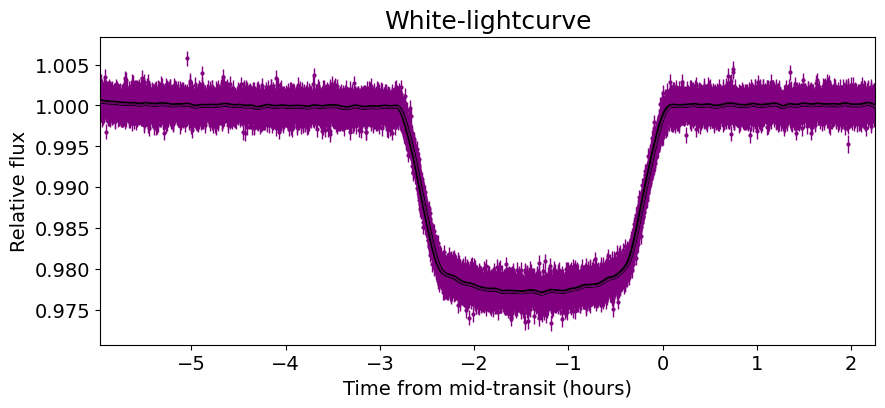

In [193]:
transit_center = np.median(results.posteriors['posterior_samples']['t0_p1'])
plt.figure(figsize=(10,4))

normalized_time = (t - transit_center) * 24
sigma_PRISM = np.median(results.posteriors['posterior_samples']['sigma_w_PRISM']*1e-6)
total_errors = np.sqrt(sigma_PRISM**2 + dataset.errors_lc['PRISM']**2)
    
plt.errorbar(normalized_time, \
                 dataset.data_lc['PRISM'], \
                 yerr = total_errors, \
                 fmt = '.', color = 'purple', ms = 4, elinewidth = 1, zorder = 1)
    
# Evaluate model:
transit_model, transit_up68, transit_low68  = \
                   results.lc.evaluate('PRISM', return_err=True)
    
transit_model, transit_up99, transit_low99  = \
                   results.lc.evaluate('PRISM', return_err=True, alpha = 0.99)
        
plt.plot(normalized_time, transit_model, color = 'black', lw=3, zorder=2)
        
plt.fill_between(normalized_time, transit_up68, transit_low68, \
                     color='purple',alpha=0.5, zorder=3)
    
plt.fill_between(normalized_time, transit_up99, transit_low99, \
                     color='purple',alpha=0.5, zorder=3)
    
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(np.min(normalized_time), np.max(normalized_time))
plt.title('White-lightcurve', fontsize = 18)
plt.xlabel('Time from mid-transit (hours)', fontsize = 14)
plt.ylabel('Relative flux', fontsize = 14)

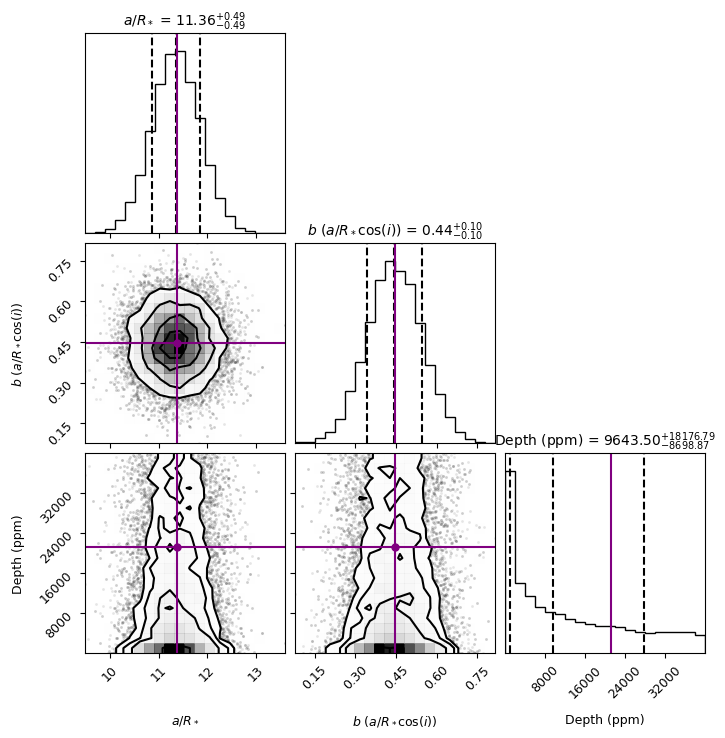

In [194]:
import corner
# Plot corner plot:
stacked_samples = np.vstack((np.vstack((results.posteriors['posterior_samples']['a_p1'], \
                                        results.posteriors['posterior_samples']['b_p1'])), \
                                       (results.posteriors['posterior_samples']['p_p1']**2)*1e6)).T

figure = corner.corner(stacked_samples, labels = [r"$a/R_*$", r"$b$ ($a/R_* \cos(i)$)", r"Depth (ppm)"],\
                       quantiles=[0.16, 0.5, 0.84],\
                       show_titles=True, title_kwargs={"fontsize": 10})

true_values = [11.37, 0.447, (0.14576**2)*1e6] # best guesses from the NASA Exoplanet archive
axes = np.array(figure.axes).reshape((3, 3)) 

# Loop over histograms:
for i in range(3):
    ax = axes[i,i]
    ax.axvline(true_values[i], color = 'purple')

# Now loop over 2D surfaces:
for yi in range(3):
    for xi in range(yi):
        ax = axes[yi, xi] 
        ax.axvline(true_values[xi], color = 'purple')
        ax.axhline(true_values[yi], color = 'purple')
        ax.plot(true_values[xi], true_values[yi], 'o', mfc = 'purple', mec = 'purple')

You can then use the same process to fit the spectral light curve and obtain a transmission spectrum.

In [115]:
t0 = 2459787.5567417163
a = 11.328210411169186
b = 0.45860700663403464


#Saving data for spectral light curves fitting

# First, define common priors for all the datasets

params = ['P_p1', 't0_p1', 'a_p1', 'b_p1', 'q1_SOSS', 'q2_SOSS', 'ecc_p1', 'omega_p1', 
          'p_p1', 'mdilution_PRISM', 'mflux_PRISM', 'sigma_w_PRISM', 'GP_sigma_PRISM', 'GP_rho_PRISM']

dists = ['fixed', 'fixed', 'fixed', 'fixed', 'uniform', 'uniform', 'fixed', 'fixed', 
         'uniform', 'fixed', 'normal', 'loguniform', 'loguniform', 'loguniform']

hyperps = [period, t0, a, b, [ 0., 1.], [0., 1.], 0., 90., 
          [0., 0.2], 1.0, [0., 0.1], [10., 10000.], [1e-6, 1e2], [1e-5, 1e3]]
    
    
prior = juliet.generate_priors(params, dists, hyperps)


# Same for starting points:
starting_point = {}
starting_point['p_p1'] = 0.1
starting_point['mflux_PRISM'] = 0.0
starting_point['sigma_w_PRISM'] = 100.
starting_point['GP_sigma_PRISM'] = 0.1
starting_point['GP_rho_PRISM'] = 0.1
starting_point['q1_PRISM'] = 0.
starting_point['q2_PRISM'] = 0.


# Now paste datasets:

data_dictionary = {}
priors = {}
starting_points = {}
wavelengths = list(lcs_binned['spectral light curves'].keys())
idx = np.where(~np.isnan(wavelengths))
wavelengths = np.array(wavelengths)[idx]
idx = np.argsort(wavelengths)
wavelengths = wavelengths[idx] 
for i in range(0, len(wavelengths)):
        
        mean_wavelength = wavelengths[i]
        name = 'wbin_' + str( np.round(mean_wavelength, 4) )
        
        # Create dictionary for current wavelength bin:
        data_dictionary[name] = {}
        
        # Fill data in:
        data_dictionary[name]['times'] = t
        data_dictionary[name]['GP_external_parameters'] = t
        
        data_dictionary[name]['flux'] = 0.
        data_dictionary[name]['error'] = 0.
        
        data_dictionary[name]['flux'] =  lcs_binned['spectral light curves'][mean_wavelength]['flux'] 
        data_dictionary[name]['error'] = lcs_binned['spectral light curves'][mean_wavelength]['errors']**2
            
        oot_flux = np.nanmedian(data_dictionary[name]['flux'][:500])
            
        data_dictionary[name]['flux'] = (data_dictionary[name]['flux'] / oot_flux)
        data_dictionary[name]['error'] = np.sqrt(data_dictionary[name]['error']) / oot_flux
        
        # Replace extreme outliers:
        residuals = data_dictionary[name]['flux'] - median_filter(data_dictionary[name]['flux'], 11)
        sigma = ts.utils.get_mad_sigma(np.nanmedian(residuals), residuals)
        idx_outliers = np.where(np.abs(residuals) > 5*sigma)[0]
        
        if len(idx_outliers) > 0:
            
            print('Found', len(idx_outliers), 'outliers on', name,'! Replacing...')
            
            for idx in idx_outliers:
                
                if idx == 0:
                    
                    replacement = 1
                    
                elif idx == len(residuals)-1:
                    
                    replacement = len(residuals)-2
                    
                else:
                    
                    replacement = idx + 1
                    
                    if replacement in idx_outliers:
                        if replacement == len(residuals) -1:
                            replacement = replacement -2
                        else:    
                        
                            replacement = idx + 2
                        
                            data_dictionary[name]['flux'][idx] = data_dictionary[name]['flux'][replacement]
                            data_dictionary[name]['error'][idx] = data_dictionary[name]['error'][replacement]
        
        # Generate priors and starting_points:
        priors[name] = copy.deepcopy(prior)
        starting_points[name] = copy.deepcopy(starting_point)
        
print( 'lcs', len(data_dictionary.keys()))
# Dump pickle files:
pickle.dump(data_dictionary, open('unbinned_data_dictionary_w39b_bin.pkl', 'wb'))
pickle.dump(priors, open('unbinned_priors_w39b_bin.pkl', 'wb'))
pickle.dump(starting_points, open('unbinned_starting_points_w39b_bin.pkl', 'wb'))

lcs 432
